In [1]:
import os
import sys
sys.path.insert(0, os.path.realpath('__file__'))

import numpy as np
import matplotlib.pyplot as plt
import pickle
import pyidi

%load_ext autoreload
%autoreload 2
%matplotlib inline

Specify the `.cih` file that has the same name as `.mraw` file with images:

In [2]:
filename = 'data/data_showcase.cih'

Make an instance of `pyIDI` class:

In [3]:
video = pyidi.pyIDI(filename)

C:\ProgramData\Anaconda3\lib\site-packages\pyMRAW.py:91: UserWarning: Not 12bit (8 bits)! clipped values?
  warnings.warn('Not 12bit ({:g} bits)! clipped values?'.format(bits))
C:\ProgramData\Anaconda3\lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 75, Original total frame: 15000)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


Information about video can be found in `.info` attribute and images are stored in `.mraw` attribute:

In [4]:
video.info

{'Date': '2018/12/17',
 'Time': '12:48',
 'Camera Type': 'FASTCAM SA-Z type 2100K-M-64GB',
 'Head Type': 'Unknown Child Device',
 'Camera ID': 11,
 'Camera Number': 0,
 'Head Number': 1,
 'Max Head Number': 1,
 'Scene Name': '',
 'User Defined Camera Name': '',
 'Session Number': '',
 'Date Record': 'Unknown',
 'Time Record': 'Unknown',
 'Trigger Time': 0,
 'Record Rate(fps)': 15000,
 'Shutter Speed(s)': '1/15371',
 'Trigger Mode': 'Start',
 'Original Total Frame': 15000,
 'Total Frame': 75,
 'Start Frame': 0,
 'Correct Trigger Frame': 0,
 'Save Step': 100,
 'Image Width': 640,
 'Image Height': 40,
 'Color Type': 'Mono',
 'Color Bit': 8,
 'File Format': 'MRaw',
 'EffectiveBit Depth': 12,
 'EffectiveBit Side': 'Higher',
 'Digits Of File Number': 6,
 'Device Last Error': '-1:0xffffffff',
 'Comment Text': '',
 'AnalogBoard Channel Num': 0,
 'Zero Frame': 'Exist',
 'Shutter Type2(nsec)': 65060,
 'Edge Enhance': 0,
 'Pre LUT Mode': 'DEF1',
 'Pre LUT Brightness': 0,
 'Pre LUT Contrast': 0,
 

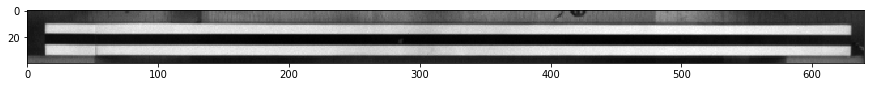

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(video.mraw[0], 'gray')

Points where the displacements will be identified must be determined. Chosen points must have high gradient value.

In [6]:
reference_image = np.average(video.mraw[:10], axis=0)

grad0, grad1 = np.gradient(reference_image)

In [7]:
inds = np.array([[ 26,  20],
               [ 18, 180],
               [ 26, 340],
               [ 26, 500]])

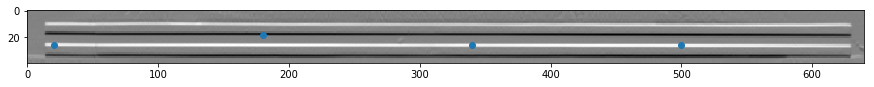

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(grad0, 'gray')
ax.scatter(inds[:, 1], inds[:, 0])

Setting the points and method to be used:

In [9]:
video.set_points(points=inds)
video.set_method('sof')

In [10]:
video.method.configure(subset_size=3) # Configuring the arguments

If the `points` argument is not given and the `method` is supplied to `set_points`, the `get_points` method is triggered. 

`kwargs` can be passed to `get_points`.

In [11]:
# video.set_points(method='simplified_optical_flow', subset=(20, 20), axis=0)

The displacements are identified by calling `get_displacements`

In [12]:
displacements = video.get_displacements()

100%|█████████████████████████████████████████████████| 75/75 [00:00<00:00, 1060.71it/s]


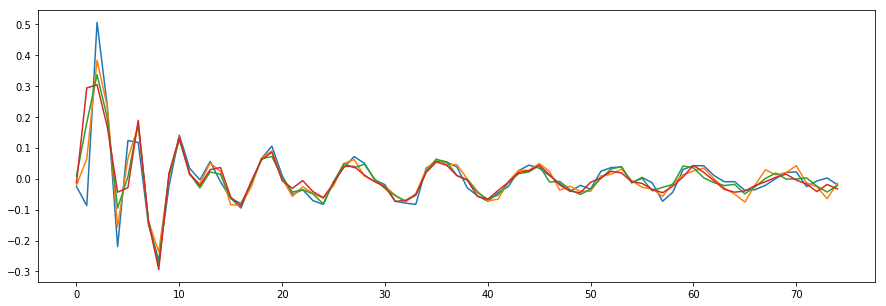

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(displacements[:, :, 0].T);

The identification method can be changed:

In [14]:
video.set_method(method='lk')

In [15]:
displacements_1 = video.get_displacements(roi_size=19)

Interpolating the reference image...
...done in 0.00 s


100%|███████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 74.01it/s]


Time to complete: 1.0 s


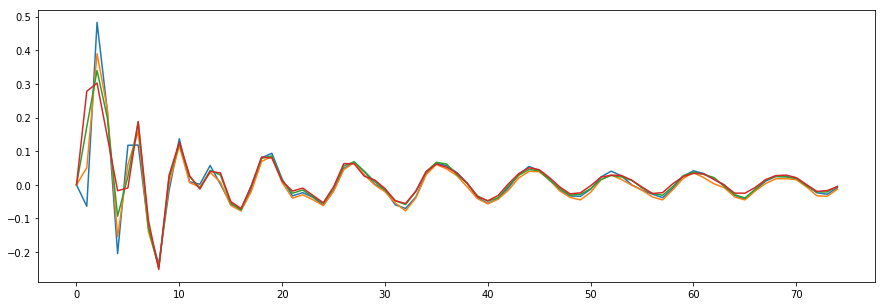

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(displacements_1[:, :, 0].T);

In [17]:
video.close_video()

To save the results of calculation, run:

In [18]:
# video.save('filename.pkl')

# Lucas-Kanade

Lucas-Kanade method is shown on synthetic data.

In [19]:
filename_2 = 'data/data_synthetic.cih'
video_2 = pyidi.pyIDI(filename_2)
video_2.info

{'Record Rate(fps)': 1,
 'Shutter Speed(s)': 1.0,
 'Total Frame': 101,
 'Original Total Frame': 101,
 'Start Frame': 0,
 'Image Width': 256,
 'Image Height': 128,
 'Color Type': 'Mono',
 'Color Bit': 16,
 'File Format': 'MRaw',
 'EffectiveBit Depth': 12,
 'EffectiveBit Side': 'Lower',
 'Comment Text': 'Generated sequence.<br>Modify measurement info in<br>created .cih file if necessary.'}

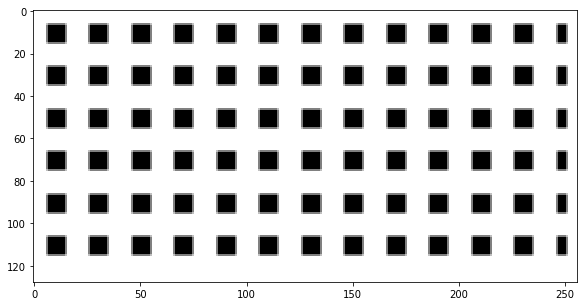

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(video_2.mraw[0], 'gray');

In [21]:
reference_image_2 = np.average(video_2.mraw[:10], axis=0)
grad0_2, grad1_2 = np.gradient(reference_image_2)

In [22]:
inds_2 = np.array([
    [ 31,  35],
    [ 91,  35],
    [ 31, 215],
    [ 91, 215],
    [ 31, 126],
    [ 91, 126],
    [ 66,  71],
    [ 35,  71],
    [ 95,  71],
    [ 66, 191],
    [ 35, 191],
    [ 95, 191]
])

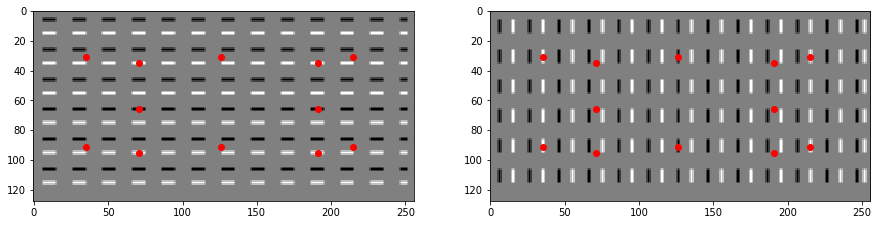

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].imshow(grad0_2, 'gray')
ax[0].scatter(inds_2[:, 1], inds_2[:, 0], c='r')
ax[1].imshow(grad1_2, 'gray')
ax[1].scatter(inds_2[:, 1], inds_2[:, 0], c='r');

In [24]:
generated_t, generated_x, generated_y = np.load('./data/data_synthetic_generated.npy')

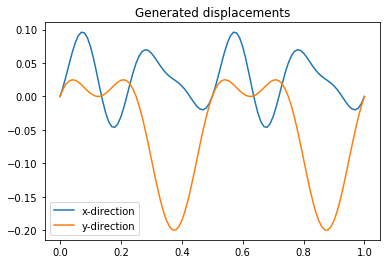

In [25]:
plt.plot(generated_t, generated_x, label='x-direction')
plt.plot(generated_t, generated_y, label='y-direction')
plt.title('Generated displacements')
plt.legend();

In [26]:
video_2.set_method('lk')
video_2.set_points(points=inds_2)

In [27]:
video_2.method.configure(show_pbar=False)

For accurate results, make sure at least 2 "speckles" are inside the ROI.

Interpolating the reference image...
...done in 0.01 s
Time to complete: 1.9 s


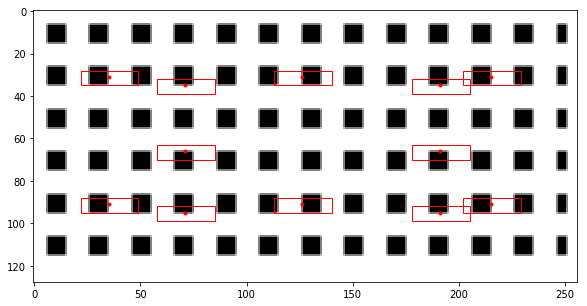

In [28]:
disp_2 = video_2.get_displacements(roi_size=(7, 27))
video_2.show_points()

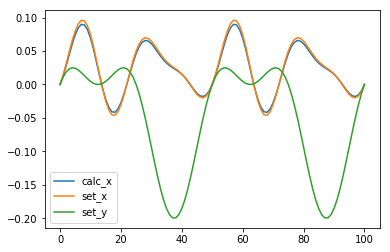

In [29]:
plt.plot(disp_2[0, :, 1] - disp_2[0, 0, 1], label='calc_x')
plt.plot(generated_x, label='set_x')
plt.plot(generated_y, label='set_y')
plt.legend()

The method can be changed and displacement calculated again:

In [30]:
video_2.set_method('sof')

In [31]:
disp_2_sof = video_2.get_displacements()

100%|███████████████████████████████████████████████| 101/101 [00:00<00:00, 1054.98it/s]


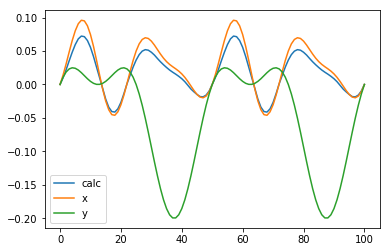

In [32]:
plt.plot(disp_2_sof[0, :, 1] - disp_2_sof[0, 0, 1], label='calc')
plt.plot(generated_x, label='x')
plt.plot(generated_y, label='y')
plt.legend()

# Multiprocessing
When using the Lucas-Kanade method, the identification can be slow, especially when large number of points is used. To reduce the computation time you can use multiprocessing:

In [33]:
video_2.set_method('lk')

In [34]:
disp_multi = video_2.get_displacements(processes=2)

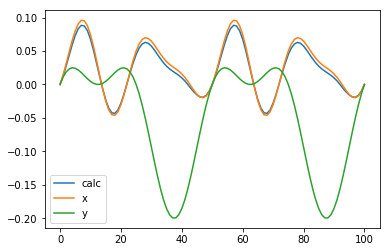

In [35]:
plt.plot(disp_multi[0, :, 1] - disp_multi[0, 0, 1], label='calc')
plt.plot(generated_x, label='x')
plt.plot(generated_y, label='y')
plt.legend()

You can monitor the progress in the command line.

In [36]:
video_2.close_video()